### Build Our Model

In [6]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]
dimention = "100x100"
npzFileName = "Uncompressed_" + dimention + ".npz"

# Load  compressed image matrix data
data = np.load(npzFileName)
ImageData_compressed = data['imageDatas_np']
print("=======done load======")

print(ImageData_compressed.shape)

=======done load======
(3410, 100, 100, 1)


## Data Preprocessing
### 1) center the char

In [7]:
def centerChar(Img):
    dimension = len(Img)
    location = locatChar(Img)
    
    resultImg = []
    for i in range(dimension):
        row = []
        for j in range(dimension):
            row += [[np.float32(1.0)]]
            
        resultImg += [row]
    
    offset_row = int((dimension-(location[1] + 1 -location[0]))/2)    
    offset_col = int((dimension-(location[3] + 1 -location[2]))/2)
    
    for i in range(0, location[1] + 1 - location[0]):
        for j in range(0, location[3] + 1 - location[2]):
            resultImg[i + offset_row][j + offset_col][0] = Img[i + location[0]][j + location[2]][0]
    
    
    resultImg = np.array(resultImg)
    return resultImg
    
def locatChar(Img):
    dimension = len(Img)
    top = dimension
    bottom = 0
    left = dimension
    right = 0
    
    for i in range(dimension):
        for j in range(dimension):
            if Img[i][j][0] < 0.2:
                if top > i:
                    top = i
                if bottom < i:
                    bottom = i
                if left > j:
                    left = j
                if right < j:
                    right = j
    return [top, bottom, left, right]

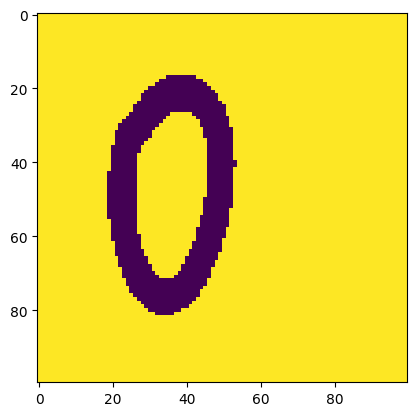

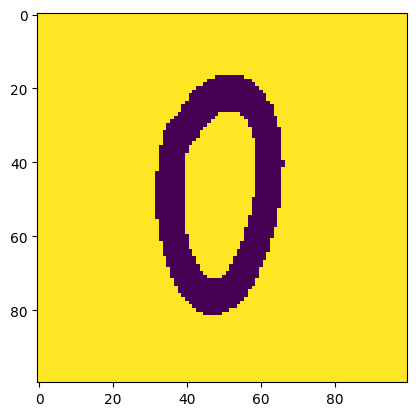

In [8]:
result = centerChar(ImageData_compressed[0])
plt.imshow(ImageData_compressed[0])
plt.show()
plt.imshow(result)
plt.show()

portion = (ImageData_compressed[0])[17:82, 19:54]
# plt.imshow(portion)
# plt.show()

In [7]:
# center all the data

ImageData_centered = []
count = 0
print("=====start processing=====")
for img in ImageData_compressed:
    img_c = centerChar(img)
    ImageData_centered += [img_c]
    
    count += 1
    if (count % 500 == 0):
        print("processed: ", count, " imgs" )

print("=====finish processing=====")

ImageData_centered = np.array(ImageData_centered)
print(ImageData_centered.shape)

=====start processing=====
processed:  500  imgs
processed:  1000  imgs
processed:  1500  imgs
processed:  2000  imgs
processed:  2500  imgs
processed:  3000  imgs
=====finish processing=====
(3410, 100, 100, 1)


In [8]:
import numpy
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Save compressed data to NPZ file
# numpy.savez(npzFileName, ImageData_centered=ImageData_centered)
# print("=======done saving======")

=======done saving======


In [9]:
import numpy
import pandas as pd
import numpy as np

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Load  compressed image matrix data
data = numpy.load(npzFileName)
ImageData_centered = data['ImageData_centered']
print("=======done loading=======")

print(ImageData_centered.shape)

=======done loading=======
(3410, 100, 100, 1)


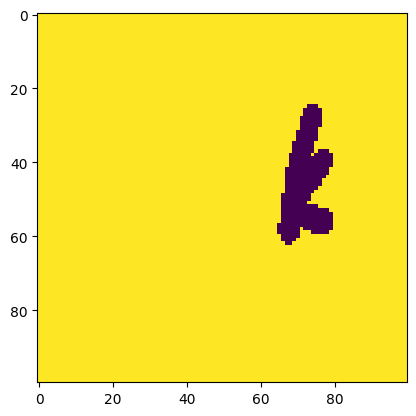

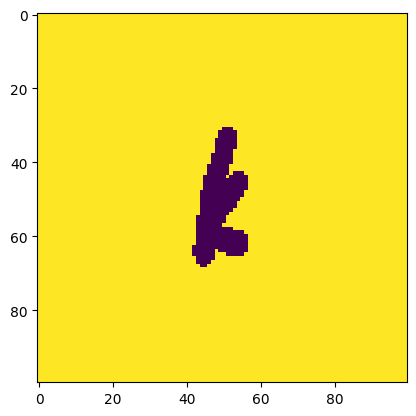

In [10]:
plt.imshow(ImageData_compressed[2578])
plt.show()
plt.imshow(ImageData_centered[2578])
plt.show()

In [11]:
def getIndex(letter):
    index = ord(letter)-48
    if (index > 10):
        index -= 7
    if (index > 35):
        index -= 6
    return index

In [98]:
from sklearn.model_selection import train_test_split

data_nparr=ImageData_centered
label_nparr=np.array(label)
label_index_nparr = np.vectorize(getIndex)(label_nparr)
label_index_onehot = pd.get_dummies(label_index_nparr) # one-hot encoded

train_data, test_data, train_label, test_label = train_test_split(data_nparr, label_index_onehot, test_size=0.1, random_state=11)
print("data splited")

data splited


In [99]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers

print("Input shape:", data_nparr[0].shape)

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=data_nparr[0].shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(62, activation='softmax'))
print("Layers added")
model.summary()

Input shape: (100, 100, 1)
Layers added
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 96, 96, 32)        832       
                                                                 
 max_pooling2d_91 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_92 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2

In [100]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("======start training======")
history = model.fit(train_data, train_label, epochs=10, 
                    validation_data=(test_data, test_label))
print("======done training======")

======start training======
Epoch 1/10
96/96 [==============================] - 11s 114ms/step - loss: 3.1139 - accuracy: 0.2408 - val_loss: 1.5701 - val_accuracy: 0.5718
Epoch 2/10
96/96 [==============================] - 11s 114ms/step - loss: 1.1045 - accuracy: 0.6882 - val_loss: 1.0196 - val_accuracy: 0.7155
Epoch 3/10
96/96 [==============================] - 11s 115ms/step - loss: 0.6368 - accuracy: 0.8084 - val_loss: 0.8592 - val_accuracy: 0.7419
Epoch 4/10
96/96 [==============================] - 11s 114ms/step - loss: 0.4469 - accuracy: 0.8563 - val_loss: 0.8449 - val_accuracy: 0.7683
Epoch 5/10
96/96 [==============================] - 11s 116ms/step - loss: 0.3151 - accuracy: 0.8980 - val_loss: 0.7927 - val_accuracy: 0.7683
Epoch 6/10
96/96 [==============================] - 12s 122ms/step - loss: 0.2494 - accuracy: 0.9163 - val_loss: 0.8429 - val_accuracy: 0.8152
Epoch 7/10
96/96 [==============================] - 11s 115ms/step - loss: 0.2031 - accuracy: 0.9299 - val_loss: 0.

In [92]:
# save model
model.save('../CNN_ver5_OHE_9-8.h5')
print("======model saved======")

======model saved======


11/11 - 0s - loss: 0.9736 - accuracy: 0.8240 - 277ms/epoch - 25ms/step


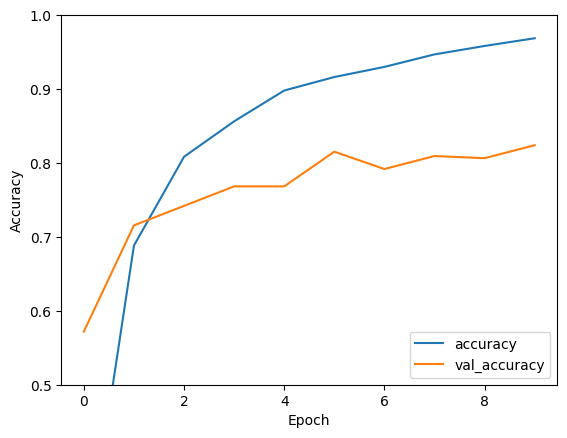

In [101]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_data,  test_label, verbose=2)

In [102]:
print(test_acc)

0.8240469098091125


In [103]:
print(type(ImageData_centered[0][0][0][0]))
print(ImageData_compressed[0].shape)
class_names = ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
# class_names = class_names[0]

test = np.array([ImageData_centered[0]])
print(test.shape)
p = model.predict(test)
print(p.shape)

# Get the indices of the largest 4 numbers
largest_indices = np.argpartition(p[0], -4)[-4:]

result = []
for index in largest_indices:
    result += [class_names[0][index]]
    
print(result)

<class 'numpy.float32'>
(100, 100, 1)
(1, 100, 100, 1)
1/1 [==============================] - 0s 53ms/step
(1, 62)
['Q', 'o', 'O', '0']


In [104]:
y_pred = model.predict(ImageData_centered)
y_actual = label_index_nparr
class_names = ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
class_names = class_names[0]

checking = 1002
print(y_pred.shape)
print(y_actual[checking])
print(class_names[y_actual[checking]])
print(np.argmax(y_pred[checking]))
print(class_names[np.argmax(y_pred[checking])])

107/107 [==============================] - 3s 26ms/step
(3410, 62)
18
I
1
1


In [105]:
Result = []
oneCharResult = []
for letter in range(len(class_names)):
    oneCharResult = []
    for predicte in range(len(class_names)):
        oneCharResult += [0]
    Result +=[oneCharResult]

allCount = 0
count = 0
count2 = 0
for i in range(3410):
    pred = np.argmax(y_pred[i])
    actual = y_actual[i]
    
    
    if pred == actual:
        count2 = count2 + 1
    else:
        count = count + 1
        actualLetter = int(i/55)
        Result[actualLetter][pred] = Result[actualLetter][pred] + 1

print(Result[0])
print(np.argmax(Result[0]))
print(class_names[np.argmax(Result[0])])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
24
O


In [106]:
falsePredict = []

for letter in range(len(class_names)):
    haveNotPrintLetter = 1
    for p in range(len(class_names)):
        if Result[letter][p] >= 1:
            if haveNotPrintLetter == 1:
                print("Letter '", class_names[letter])
                haveNotPrintLetter = 0
            print("   - mispredict: [", class_names[p], "] ",Result[letter][p])
        
    falsePredict += [np.sum(Result[letter])]
    
print(falsePredict)

Letter ' 0
   - mispredict: [ 9 ]  1
   - mispredict: [ O ]  10
   - mispredict: [ o ]  5
Letter ' 2
   - mispredict: [ 3 ]  1
Letter ' 3
   - mispredict: [ A ]  1
Letter ' 4
   - mispredict: [ f ]  2
Letter ' 5
   - mispredict: [ J ]  1
Letter ' 7
   - mispredict: [ r ]  1
Letter ' 8
   - mispredict: [ s ]  1
Letter ' 9
   - mispredict: [ P ]  1
Letter ' C
   - mispredict: [ c ]  2
Letter ' D
   - mispredict: [ O ]  1
   - mispredict: [ P ]  1
Letter ' E
   - mispredict: [ F ]  1
Letter ' H
   - mispredict: [ K ]  1
Letter ' I
   - mispredict: [ 1 ]  13
   - mispredict: [ l ]  6
Letter ' K
   - mispredict: [ k ]  1
Letter ' O
   - mispredict: [ o ]  3
Letter ' P
   - mispredict: [ p ]  1
Letter ' R
   - mispredict: [ X ]  1
Letter ' S
   - mispredict: [ s ]  5
Letter ' U
   - mispredict: [ w ]  1
Letter ' V
   - mispredict: [ W ]  1
   - mispredict: [ Y ]  2
   - mispredict: [ v ]  3
Letter ' W
   - mispredict: [ w ]  1
Letter ' X
   - mispredict: [ Y ]  1
   - mispredict: [ r ]  1
  